In [100]:
# Here we import all libraries
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
import torch
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import deque 
import sys
env = gym.make("CartPole-v0")

In [101]:
#Hyperparameters
episodes = 5000
eps = 1.0
learning_rate = 0.1
discount_factor = 0.99
tot_rewards = []
decay_val = 0.001
mem_size = 50000
batch_size = 200
gamma = 0.99

In [102]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, action_size)
        )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [103]:
model = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
opt = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
loss = nn.MSELoss()
replay_buffer = deque(maxlen=mem_size)

In [104]:
state = torch.tensor(env.reset(), dtype=torch.float32)
state = state.unsqueeze(dim=0)
out = model(state)

In [105]:
def compute_td_loss(batch_size):
    state, next_state, reward, done, action = zip(*random.sample(replay_buffer, batch_size))
    print("state = ", state)
    state = torch.from_numpy(np.array(state).reshape(-1, 1)).unsqueeze(dim = 0).type(torch.float32)
    next_state = torch.from_numpy(np.array(next_state).reshape(-1, 1)).unsqueeze(dim = 0).type(torch.float32)
    reward = torch.from_numpy(np.array(reward))
    done = torch.from_numpy(np.array(done))
    action = torch.from_numpy(np.array(action)).type(torch.int64)
    print("state = ", state)
    q_values = model(state)
    next_q_values = model(next_state)
    q_vals = q_values.squeeze().gather(dim=-1, index=action.reshape(-1,1)).reshape(1, -1)
    max_next_q_values = torch.max(next_q_values,2)[0].detach()

    loss = 0.5*((reward + gamma*max_next_q_values - q_vals)**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss
    

Episode =  0


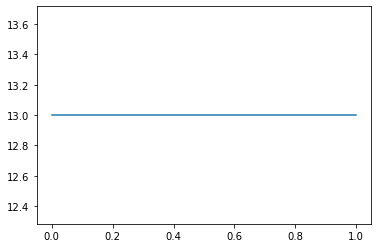

Episode =  1
Episode =  2
Episode =  3
Episode =  4
Episode =  5
Episode =  6
Episode =  7
Episode =  8
Episode =  9
Episode =  10
Episode =  11
state =  (array([ 0.07921819,  1.0160968 , -0.07208857, -1.5208706 ], dtype=float32), array([ 0.14834575,  0.96299255, -0.17177689, -1.6100773 ], dtype=float32), array([-0.01217928,  0.16982079, -0.01237666, -0.25308505], dtype=float32), array([ 0.03269401,  0.03590543, -0.0193199 ,  0.04614834], dtype=float32), tensor([[ 0.0283,  0.7573, -0.0741, -1.1807]]), array([-0.01989091,  0.63054943, -0.08431594, -1.0088893 ], dtype=float32), array([ 0.01327607,  0.65648323, -0.13110036, -1.364099  ], dtype=float32), array([ 0.08720495,  0.95754635, -0.0738156 , -1.4729228 ], dtype=float32), array([-0.04675761,  0.23726988, -0.04248014, -0.35401   ], dtype=float32), array([-9.0299696e-02, -7.8691626e-01,  9.4244169e-04,  9.5368046e-01],
      dtype=float32), array([ 0.01106145, -0.13526702, -0.03752597,  0.06463527], dtype=float32), array([-0.02212387,

c:\users\thoma\anaconda3\envs\custom_atari_env\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [106]:
for i in range(episodes):
    print("Episode = ", i)
    state = env.reset()
#     print("state = ",state)
    done = False
    steps = 0
    eps_rew = 0 
    while not done and steps<50:
        if np.random.uniform(0,1)<eps:
            action = env.action_space.sample()

        else:
            state = torch.tensor(state, dtype=torch.float32)
            state = state.unsqueeze(dim=0)
            action = np.argmax(model(state).detach().numpy())
        next_state, reward, done, info = env.step(action)
        replay_buffer.append((state, next_state, reward, done, action))
        if len(replay_buffer)>batch_size:
            loss = compute_td_loss(batch_size)
        eps = eps/(1 + 0.001)
        eps_rew += reward 
        if done:
            tot_rewards.append(eps_rew)
            break
        
        state = next_state
        steps += 1
    tot_rewards.append(eps_rew)
    
    if(i%100)==0:
        plt.plot(tot_rewards)
        plt.show()

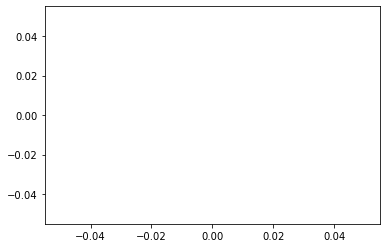

In [99]:
#Plot
plt.plot(tot_rewards)

In [25]:
#Render the final environment
state, info = env.reset(seed=42, return_info=True)
import time
for i in range(100):
    
    print("i = ", i)
    env.render()
    
    state = torch.tensor(state, dtype=torch.float32)
    state = state.unsqueeze(dim=0)
    action = np.argmax(model(state).detach().numpy())
    print("action = ", action)
    state, reward, done, info = env.step(action)

    if done:
        state, info = env.reset(return_info=True)
env.close()

i =  0


c:\users\thoma\anaconda3\envs\custom_atari_env\lib\site-packages\gym\core.py:58: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


action =  3
i =  1


c:\users\thoma\anaconda3\envs\custom_atari_env\lib\site-packages\gym\core.py:58: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


action =  3
i =  2
action =  3
i =  3
action =  3
i =  4
action =  3
i =  5
action =  3
i =  6
action =  3
i =  7
action =  3
i =  8
action =  3
i =  9
action =  3
i =  10
action =  3
i =  11
action =  3
i =  12
action =  3
i =  13
action =  3
i =  14
action =  3
i =  15
action =  3
i =  16
action =  3
i =  17
action =  3
i =  18
action =  3
i =  19
action =  3
i =  20
action =  3
i =  21
action =  3
i =  22
action =  3
i =  23
action =  3
i =  24
action =  3
i =  25
action =  3
i =  26
action =  3
i =  27
action =  3
i =  28
action =  3
i =  29
action =  3
i =  30
action =  3
i =  31
action =  3
i =  32
action =  3
i =  33
action =  3
i =  34
action =  3
i =  35
action =  3
i =  36
action =  3
i =  37
action =  3
i =  38
action =  3
i =  39
action =  3
i =  40
action =  3
i =  41
action =  3
i =  42
action =  3
i =  43
action =  3
i =  44
action =  3
i =  45
action =  3
i =  46
action =  3
i =  47
action =  3
i =  48
action =  3
i =  49
action =  3
i =  50
action =  3
i =  51
action =

KeyboardInterrupt: 

In [84]:
env.observation_space.shape[0]
env.action_space.n

2